In [29]:
import pandas as pd
import numpy as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
# import talib as ta

[*********************100%***********************]  1 of 1 completed


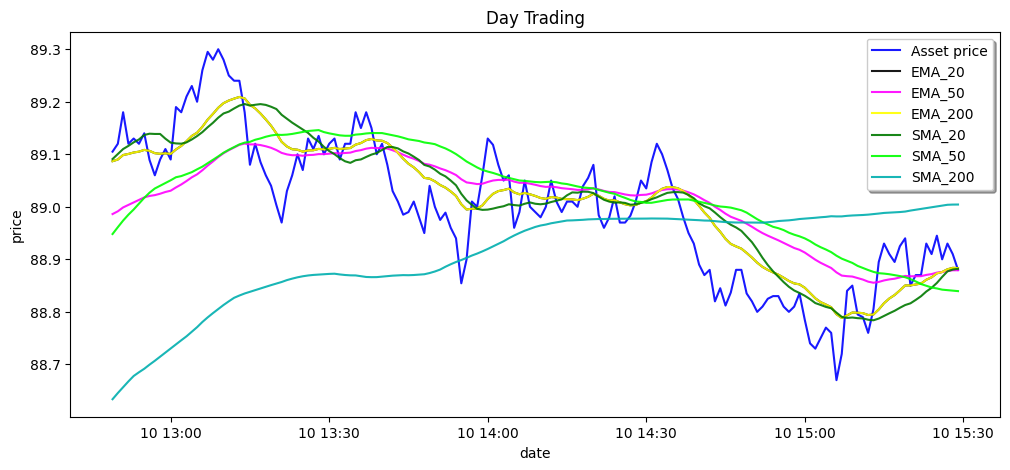

None


In [47]:
class MovingAverageDayTrading():

    def __init__(self, ticker, stop_loss=0.05, take_profit=0.1):
        self.ticker = ticker
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        # This way, when an instance of the class is created, the self.stop_loss and self.take_profit will be set with default values of 0.05 and 0.1 respectively. These values can be overridden when an instance of the class is created by passing a different value for stop_loss and take_profit.

    def moving_average_timeframes(self):
        
        
        end= datetime.today()
        start = end - timedelta(days=1)
        df = yf.download(self.ticker, start= start ,end= end, interval='1m')
        # Exponential Moving Averages
        df['EMA_20'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
        df['EMA_50'] = df['Adj Close'].ewm(span=50, adjust=False).mean()
        df['EMA_200'] = df['Adj Close'].ewm(span=20, adjust=False).mean()
        
        # Simple Moving Averages
        df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Adj Close'].rolling(window=50).mean()
        df['SMA_200'] = df['Adj Close'].rolling(window=200).mean()
        
        # # Bollinger Bands
        # df['BOL_upper'], df['BOL_middle'], df['BOL_lower'] = ta.BBANDS(df["Adj Close"])
        
        # # Stochastic Oscillator
        # df['STO_slowk'], df['STO_slowd'] = ta.STOCH(df["High"], df["Low"], df["Adj Close"])
        
        # # Relative Strength Index
        # df['RSI'] = ta.RSI(df["Adj Close"])
        
        # # Moving Average Convergence Divergence
        # df['MACD'], df['MACD_signal'], df['MACD_hist'] = ta.MACD(df["Adj Close"])

        # The idea here is to now have access to various indicators and technical analysis for the current ticker and by having different timeframes for each one of the indicators (20,50,200) you can have a better understanding of the current state of the market.
        # Additionally you could use the `df` dataframe to plot these indicators, and analyze the data to identify potential buy and sell signals, and also use it to perform some backtesting to evaluate the performance of your strategy over time, as well as create stop loss and take profit conditions.
        # dates = df.values[:, 0]
        # print(dates)
        df = df.dropna()
        df = df[['Adj Close', 'EMA_20', 'EMA_50', 'EMA_200','SMA_20', 'SMA_50', 'SMA_200']]
        
        if self.stop_loss is None or self.take_profit is None:
            raise ValueError("stop_loss and take_profit values must be set before using them")

        buy = []
        sell = []
        for i in range(1, len(df)):
            # Check for buy signal
            if (df['EMA_20'][i] > df['EMA_50'][i] and df['EMA_20'][i-1] < df['EMA_50'][i-1]) and (df['EMA_20'][i] > df['EMA_200'][i] and df['EMA_20'][i-1] < df['EMA_200'][i-1]) and (df['SMA_20'][i] > df['SMA_50'][i] and df['SMA_20'][i-1] < df['SMA_50'][i-1]) and (df['SMA_20'][i] > df['SMA_200'][i] and df['SMA_20'][i-1] < df['SMA_200'][i-1]):
                buy.append((df.index[i], df['Adj Close'][i]))
                current_price = df['Adj Close'][i]
                stop_loss_price = current_price * (1 - self.stop_loss)
                take_profit_price = current_price * (1 + self.take_profit)
                
                # Implement stop loss and take profit
                for j in range(i, len(df)):
                    if df['Adj Close'][j] < stop_loss_price:
                        sell.append((df.index[j], df['Adj Close'][j]))
                        break
                    elif df['Adj Close'][j] > take_profit_price:
                        sell.append((df.index[j], df['Adj Close'][j]))
                        break
            # Check for sell signal   
            elif (df['EMA_20'][i] < df['EMA_50'][i] and df['EMA_20'][i-1] > df['EMA_50'][i-1]) and (df['EMA_20'][i] < df['EMA_200'][i] and df['EMA_20'][i-1] > df['EMA_200'][i-1]) and (df['SMA_20'][i] < df['SMA_50'][i] and df['SMA_20'][i-1] > df['SMA_50'][i-1]) and (df['SMA_20'][i] < df['SMA_200'][i] and df['SMA_20'][i-1] > df['SMA_200'][i-1]):
                sell.append((df.index[i], df['Adj Close'][i]))

        
        # plt.plot()
        plt.figure(figsize=(12,5))
        plt.xlabel("date")
        plt.ylabel("price")
        plt.plot(df['Adj Close'], label= 'Asset price', c='blue', alpha=0.9)
        plt.plot(df['EMA_20'], label='EMA_20', c='k', alpha= 0.9)
        plt.plot(df['EMA_50'], label='EMA_50', c='magenta', alpha= 0.9)
        plt.plot(df['EMA_200'], label='EMA_200', c='yellow', alpha= 0.9)
        plt.plot(df['SMA_20'], label='SMA_20', c='#007900', alpha= 0.9)
        plt.plot(df['SMA_50'], label='SMA_50', c='#00ff00', alpha= 0.9)
        plt.plot(df['SMA_200'], label='SMA_200', c='#00aeae', alpha= 0.9)
        # plt.plot(df['BOL_upper'], label='BOL_upper', c='#ff7f00', alpha= 0.9)
        # plt.plot(df['STO_slowk'], label='STO_slowk', c='#7308a5', alpha= 0.9)
        # plt.plot(df['RSI'], label='RSI', c='#ffff00', alpha= 0.9)
        # plt.plot(df['MACD'], label='MACD', c='#feb300', alpha= 0.9)
        
        plt.scatter(df.iloc[buy].index,df.iloc[buy]['Adj Close'], marker='^', color='g', s=100)
        plt.scatter(df.iloc[sell].index,df.iloc[sell]['Adj Close'], marker='v', color='r', s=100)

        plt.title('Day Trading')
        plt.legend(shadow=True)
        return plt.show()

if __name__ == '__main__':
    
    average = MovingAverageDayTrading('GOOG', stop_loss=0.03, take_profit=0.15)
    print(average.moving_average_timeframes())
    #     The function MovingAverageDayTrading("AAPL", stop_loss=0.03, take_profit=0.15) is an example of creating an instance of the MovingAverageDayTrading class and passing in the required parameters for the class.
    # Here, the string "AAPL" is passed as the value for the ticker attribute, and stop_loss and take_profit are set as 0.03 and 0.15 respectively.
    # You would use this line of code when you want to use the class to analyze "AAPL" stock and you have set stop_loss as 3% and take_profit as 15%.
    # You can replace "AAPL" with any other stock ticker of your choice and can change the stop_loss and take_profit as well as per your requirement.
    # It's important to note that this code will only work if the class MovingAverageDayTrading exists in the current environment and has the correct definition, including the constructor function with the parameters as described above.